# Exploring data interoperability with STAC and the Microsoft Planetary Computer

By [Pete Gadomski](https://github.com/gadomski).

Initially presented at PECORA 2022 on 26 Oct in Denver.

## Requirements

Install into your Python environment, e.g. w/ [pip](https://pypi.org/project/pip/).

- [pystac-client](https://pystac-client.readthedocs.io/en/stable/)
- [rich](https://rich.readthedocs.io/en/stable/)
- [folium](https://python-visualization.github.io/folium/)
- [shapely](https://shapely.readthedocs.io/en/stable/manual.html)
- [odc-stac](https://odc-stac.readthedocs.io/en/latest/)
- [planetary-computer](https://pypi.org/project/planetary-computer/)
- [dask-gateway](https://gateway.dask.org/) (optional)

## Discovery

First, let's find out what collections are available to us on the Planetary Computer.
We'll use [pystac-client](https://pystac-client.readthedocs.io/en/stable/) to query the Planetary Computer's [STAC API](https://github.com/radiantearth/stac-api-spec).

In [1]:
from pystac_client import Client
from rich.table import Table

PLANETARY_COMPUTER = "https://planetarycomputer.microsoft.com/api/stac/v1"
client = Client.open(PLANETARY_COMPUTER)
collections = list(client.get_all_collections())
collections.sort(key=lambda c: c.id)
table = Table("ID", "Title", title="Planetary Computer collections")
for collection in collections:
    table.add_row(collection.id, collection.title)
table

                                        Planetary Computer collections                                         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ ID                          ┃ Title                                                                         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 3dep-lidar-classification   │ USGS 3DEP Lidar Classification                                                │
│ 3dep-lidar-copc             │ USGS 3DEP Lidar Point Cloud                                                   │
│ 3dep-lidar-dsm              │ USGS 3DEP Lidar Digital Surface Model                                         │
│ 3dep-lidar-dtm              │ USGS 3DEP Lidar Digital Terrain Model                                         │
│ 3dep-lidar-dtm-native       │ USGS 3DEP Lidar Digital Terrain Model (Native)                                │
│ 3dep-lidar-hag              │ USGS 3DEP Lidar Height above Ground                                           │
│ 3dep-lidar-intensity        │ USGS 3DEP Lidar Intensity                                                     │
│ 3dep-lidar-pointsourceid    │ USGS 3DEP Lidar Point Source                                                  │
│ 3dep-lidar-returns          │ USGS 3DEP Lidar Returns                                                       │
│ 3dep-seamless               │ USGS 3DEP Seamless DEMs                                                       │
│ alos-dem                    │ ALOS World 3D-30m                                                             │
│ alos-fnf-mosaic             │ ALOS Forest/Non-Forest Annual Mosaic                                          │
│ alos-palsar-mosaic          │ ALOS PALSAR Annual Mosaic                                                     │
│ aster-l1t                   │ ASTER L1T                                                                     │
│ chloris-biomass             │ Chloris Biomass                                                               │
│ cil-gdpcir-cc-by            │ CIL Global Downscaled Projections for Climate Impacts Research (CC-BY-4.0)    │
│ cil-gdpcir-cc-by-sa         │ CIL Global Downscaled Projections for Climate Impacts Research (CC-BY-SA-4.0) │
│ cil-gdpcir-cc0              │ CIL Global Downscaled Projections for Climate Impacts Research (CC0-1.0)      │
│ cop-dem-glo-30              │ Copernicus DEM GLO-30                                                         │
│ cop-dem-glo-90              │ Copernicus DEM GLO-90                                                         │
│ daymet-annual-hi            │ Daymet Annual Hawaii                                                          │
│ daymet-annual-na            │ Daymet Annual North America                                                   │
│ daymet-annual-pr            │ Daymet Annual Puerto Rico                                                     │
│ daymet-daily-hi             │ Daymet Daily Hawaii                                                           │
│ daymet-daily-na             │ Daymet Daily North America                                                    │
│ daymet-daily-pr             │ Daymet Daily Puerto Rico                                                      │
│ daymet-monthly-hi           │ Daymet Monthly Hawaii                                                         │
│ daymet-monthly-na           │ Daymet Monthly North America                                                  │
│ daymet-monthly-pr           │ Daymet Monthly Puerto Rico                                                    │
│ deltares-floods             │ Deltares Global Flood Maps                                                    │
│ deltares-water-availability │ Deltares Global Water Availability                                            │
│ eclipse                     │ Urban Innovation Eclipse Sensor Data            

## Getting our Landsat collection id

As you can see, there's a ton of collections.
Because this is PECORA, let's narrow in on the [Landsat](https://landsat.gsfc.nasa.gov/) collections for now.

In [2]:
from rich.markdown import Markdown

landsat_collections = [c for c in collections if c.id.startswith("landsat")]
table = Table("ID", "Title", "Description",
              title="Planetary Computer Landsat collections")
for collection in landsat_collections:
    table.add_row(collection.id,
                  collection.title,
                  Markdown(collection.description))
table

                                      Planetary Computer Landsat collections                                       
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ ID              ┃ Title                          ┃ Description                                                  ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ landsat-8-c2-l2 │ Landsat 8 Collection 2 Level-2 │ The ]8;id=885266;https://landsat.gsfc.nasa.gov/\Landsat]8;;\ program has been imaging the Earth since 1972;   │
│                 │                                │ it provides a comprehensive, continuous archive of the       │
│                 │                                │ Earth's surface.  ]8;id=789931;https://www.usgs.gov/core-science-systems/nli/landsat/landsat-8\Landsat 8]8;;\ is the most recent satellite in  │
│                 │                                │ the Landsat series.  Launched in 2013, Landsat 8 captures    │
│                 │                                │ data in eleven spectral bands: ten optical/IR bands from the │
│                 │                                │ ]8;id=43989;https://landsat.gsfc.nasa.gov/landsat-8/operational-land-imager\Operational Land Imager]8;;\ (OLI) instrument, and two thermal    │
│                 │                                │ bands from the ]8;id=392944;https://landsat.gsfc.nasa.gov/landsat-8/thermal-infrared-sensor-tirs\Thermal Infrared Sensor]8;;\ (TIRS) instrument.    │
│                 │                                │                                                              │
│                 │                                │ This dataset represents the global archive of Level-2        │
│                 │                                │ Landsat 8 data from ]8;id=169577;https://www.usgs.gov/core-science-systems/nli/landsat/landsat-collection-2\Landsat Collection 2]8;;\.  Images are stored │
│                 │                                │ in ]8;id=237901;https://www.cogeo.org/\cloud-optimized GeoTIFF]8;;\ format.                           │
│ landsat-c2-l1   │ Landsat Collection 2 Level-1   │ Landsat Collection 2 Level-1 data, consisting of quantized   │
│                 │                                │ and calibrated scaled Digital Numbers (DN) representing the  │
│                 │                                │ multispectral image data. These ]8;id=286894;https://www.usgs.gov/landsat-missions/landsat-collection-2-level-1-data\Level-1]8;;\ data can be ]8;id=129071;https://www.usgs.gov/landsat-missions/using-usgs-landsat-level-1-data-product\rescaled]8;;\ │
│                 │                                │ to top of atmosphere (TOA) reflectance and/or radiance.      │
│                 │                                │ Thermal band data can be rescaled to TOA brightness          │
│                 │                                │ temperature.                                                 │
│                 │                                │                                                              │
│                 │                                │ This dataset represents the global archive of Level-1 data   │
│                 │                                │ from ]8;id=802870;https://www.usgs.gov/core-science-systems/nli/landsat/landsat-collection-2\Landsat Collection 2]8;;\ acquired by the ]8;id=481848;https://landsat.gsfc.nasa.gov/multispectral-scanner-system/\Multispectral ]8;;\     │
│                 │                                │ ]8;id=481848;https://landsat.gsfc.nasa.gov/multispectral-scanner-system/\Scanner System]8;;\ onboard Landsat 1 through Landsat 5 from July │
│                 │                                │ 7, 1972 to January 7, 2013. Images are stored in             │
│                 │                                │ ]8;id=859982;https

## Choosing the correct Landsat collection

As you can see, there's currently three Landsat collections in the Planetary Computer.
Which one to use?
The two `landsat-c2-*` collections seem to be of a pair, but what's going on with `landsat-8-c2-l2`?

Turns out that `landsat-8-c2-l2` is an old collection that has been superseded by `landsat-c2-l2`.
There's no way to know this from the STAC metadata, though we (being the Planetary Computer team) should probably fix that by marking it deprecated with the [version extension](https://github.com/stac-extensions/version).
The deprecated collection is hidden from the website interface, if you use that.

But, for now, we'll use `landsat-c2-l2` for Landsat Level 2 data.

# Fetching and displaying data

First, let's demonstrate loading data using **pystac-client** and [odc-stac](https://github.com/opendatacube/odc-stac).
**odc-stac** is part of the [OpenDataCube](https://www.opendatacube.org/), ecosystem, but stands alone as its own software package.
If you're familiar with OpenDataCube, you know that it's primary product is a database-cum-analysis software stack used for analyzing geospatial data, not dissimilar to the Planetary Computer.
**odc-stac** represents a coming together between the OpenDataCube and the STAC ecosystems, because it take STAC items and turns them into analysis-ready xarrays using routines developed for the OpenDataCube.
**odc-stac** *does not* require a database, or any significant dependencies.

We'll define an area around Steamboat Springs, Colorado, and a datetime range during the winter.
We'll also search for items that have a sufficiently low amount enough of cloud cover to create a good mosaic.
First, let's find the STAC items that match our criteria.

In [3]:
LANDSAT_COLLECTION = "landsat-c2-l2"
# this is a simplified datetime syntax that pystac-client understands
DATETIME = "2022-06"
CLOUD_COVER_THRESHOLD = 10  # percent
BBOX = [-107.381493, 40.118423, -106.331366, 40.960106]  # Steamboat Springs, CO

item_search = client.search(
    collections=[LANDSAT_COLLECTION],
    bbox=BBOX,
    datetime=DATETIME,
    query=[f"eo:cloud_cover<={CLOUD_COVER_THRESHOLD}"],
)
item_collection = item_search.item_collection()
print(f"Found {len(item_collection)} items")

Found 4 items


## Showing the STAC footprints

So far, we've only fetched STAC metadata, which are just JSON objects.
We haven't fetched any raster data at all.
How do the footprints of our STAC items relate to our bounding box of interest?
Let's look, using **folium**.

In [4]:
from folium import Map, GeoJson
from shapely.geometry import box

item_style_function = lambda s: {
    "color": "#8da0cbaa"
}
bbox_style_function = lambda s: {
    "color": "#fc8d62"
}

map = Map(tiles="Stamen Watercolor")
minx = 180
maxx = -180
miny = 90
maxy = -90
for item in item_collection:
    if item.bbox[0] < minx:
        minx = item.bbox[0]
    if item.bbox[1] < miny:
        miny = item.bbox[1]
    if item.bbox[2] > maxx:
        maxx = item.bbox[2]
    if item.bbox[3] > maxy:
        maxy = item.bbox[3]
    GeoJson(item.to_dict(), style_function=item_style_function).add_to(map)
GeoJson(box(*BBOX), style_function=bbox_style_function).add_to(map)
map.fit_bounds([[miny, minx], [maxy, maxx]])
display(map)

## Reading data only in our area of interest

As you can see, the item bounds extend well beyond our bounding box of interest.
While we could load all the data from all items, that's inefficient.
**odc-stac** can use our bounding box and the fact that our Landsat data is stored as Cloud-Optimized GeoTIFFs (COGs) to only read the bits we need, not all of the data.
Let's show that in action, loading only the RGB bands for quick visualization.
Note that we use the Planetary Computer API to sign the asset hrefs, which appends a Shared Access Signature (SAS) to allow access to the data assets.

We load the data at 100m resolution to speed up display operations.
For analysis, you'll most likely want to load at native resolution.

In [5]:
import odc.stac
import planetary_computer

item_collection = planetary_computer.sign_item_collection(item_collection)
data = odc.stac.load(
    item_collection,
    bands=["red", "green", "blue"],
    groupby="solar_day",
    bbox=BBOX,
    resolution=100
)
data

<xarray.Dataset>
Dimensions:      (y: 954, x: 910, time: 2)
Coordinates:
  * y            (y) float64 4.537e+06 4.537e+06 ... 4.442e+06 4.442e+06
  * x            (x) float64 2.97e+05 2.972e+05 2.972e+05 ... 3.878e+05 3.88e+05
    spatial_ref  int32 32613
  * time         (time) datetime64[ns] 2022-06-13T17:49:25.196177 2022-06-21T...
Data variables:
    red          (time, y, x) uint16 10584 10496 10866 ... 11885 12865 13391
    green        (time, y, x) uint16 10357 10328 10506 ... 11319 12042 12456
    blue         (time, y, x) uint16 9239 9215 9397 9430 ... 9873 10623 10949

## Plotting RGB data

There's nothing better than visualizing your data as full-color images.

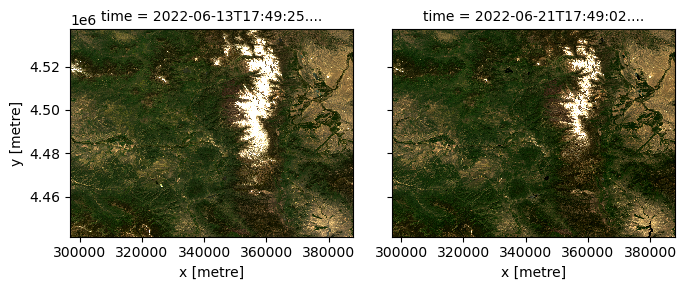

In [6]:
rgb_data = data.odc.to_rgba(vmin=1, vmax=15000, bands=["red", "green", "blue"])
rgb_data.plot.imshow(col="time", rgb="band", robust=True)

## Monthly composite using dask

This is all pretty easy work, and works moderatly well when running in a synchronous execution environment.
However, when trying to scale up this type of work into large spatial and temporal domains, some problems are easily parallelizable.
[Dask](https://www.dask.org/) is a powerful parallel execution enviornment that works well in single-user, large data environments, such as geospatial analysis.
The Planetary Computer Hub includes a Dask Gateway cluster for use for analysis; you can also set up Dask Gateway using [local processes](https://gateway.dask.org/install-local.html), e.g. on your laptop.

First, let's set up a gateway cluster.
You can click on the dashboard link to see the execution status of the Dask cluster.

In [7]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
dask_client = cluster.get_client()
cluster.adapt(minimum=4, maximum=24)
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.3b17d5187b1b4308a32f3fb5c90e3f86/status


Next, let's find images for the same area of interest, but this time for the whole year of 2021.

In [8]:
item_search = client.search(
    collections=[LANDSAT_COLLECTION],
    bbox=BBOX,
    datetime="2021",
    query=[f"eo:cloud_cover<=25"],
)
item_collection = planetary_computer.sign_item_collection(item_search.item_collection())
print(f"Found {len(item_collection)} items")

Found 65 items


By using the `chunks` option to `odc.stac.load`, we instruct **odc-stac** to break up the data loading into a set of tasks, which will be fanned out to Dask workers on request.
Note that we haven't actually loaded any data yet; we've only built the execution graph, or plan.
Your Dask gateway status page should be still.

In [9]:
data = odc.stac.load(
    item_collection,
    bands=["red", "green", "blue"],
    bbox=BBOX,
    resolution=100,
    groupby="solar_day",
    chunks={"x": 2048, "y": 2048},
)
data

<xarray.Dataset>
Dimensions:      (y: 954, x: 910, time: 47)
Coordinates:
  * y            (y) float64 4.537e+06 4.537e+06 ... 4.442e+06 4.442e+06
  * x            (x) float64 2.97e+05 2.972e+05 2.972e+05 ... 3.878e+05 3.88e+05
    spatial_ref  int32 32613
  * time         (time) datetime64[ns] 2021-01-01T17:49:32.270967 ... 2021-12...
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 954, 910), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 954, 910), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 954, 910), meta=np.ndarray>

By asking our xarray to persist its data, we now actually load the data into our xarray on our workers.

In [10]:
data.persist()

<xarray.Dataset>
Dimensions:      (y: 954, x: 910, time: 47)
Coordinates:
  * y            (y) float64 4.537e+06 4.537e+06 ... 4.442e+06 4.442e+06
  * x            (x) float64 2.97e+05 2.972e+05 2.972e+05 ... 3.878e+05 3.88e+05
    spatial_ref  int32 32613
  * time         (time) datetime64[ns] 2021-01-01T17:49:32.270967 ... 2021-12...
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 954, 910), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 954, 910), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 954, 910), meta=np.ndarray>

We can create monthly composites of the band data, which will be done on the Dask cluster as well.

In [11]:
monthly_data = data.groupby("time.month").median().compute()
monthly_data

<xarray.Dataset>
Dimensions:      (y: 954, x: 910, month: 12)
Coordinates:
  * y            (y) float64 4.537e+06 4.537e+06 ... 4.442e+06 4.442e+06
  * x            (x) float64 2.97e+05 2.972e+05 2.972e+05 ... 3.878e+05 3.88e+05
    spatial_ref  int32 32613
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    red          (month, y, x) float64 4.475e+04 3.911e+04 ... 3.03e+04
    green        (month, y, x) float64 4.226e+04 3.443e+04 ... 3.001e+04
    blue         (month, y, x) float64 4.25e+04 3.453e+04 ... 3.066e+04

Finally, let's display!
We could do a lot more to create better composities, but we'll leave that as an exercise for the reader.

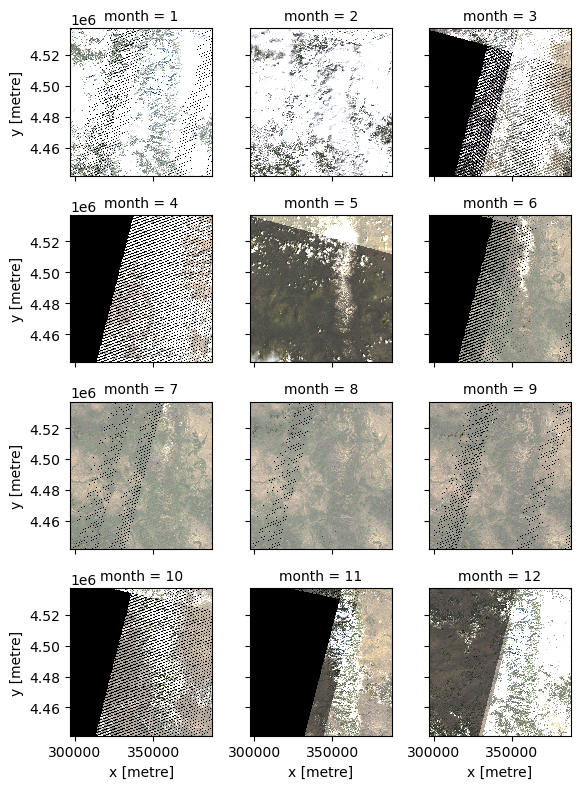

In [12]:
monthly_data_rgb = monthly_data.odc.to_rgba(vmin=1, vmax=15000, bands=["red", "green", "blue"])
monthly_data_rgb.plot.imshow(x="x", y="y", rgb="band", col="month", col_wrap=3, figsize=(6, 8))